### Introduction

In [1]:
import pickle
import os
import matplotlib.pyplot as plt

# Define the directory containing your pickle files
data_dir = "data/curiosity_deepdive"

# List of reward types to load
reward_types = ['None', 'ICM', 'E3B']

# Dictionaries to store the data
states_seen = {}
actions_taken = {}

# Loop over each reward type and load the corresponding pickle files
for reward in reward_types:
    states_path = os.path.join(data_dir, f"states_seen_{reward}.pkl")
    actions_path = os.path.join(data_dir, f"actions_taken_{reward}.pkl")
    
    with open(states_path, "rb") as f:
        states_seen[reward] = pickle.load(f)
    with open(actions_path, "rb") as f:
        actions_taken[reward] = pickle.load(f)

# Print basic info about states_seen for each reward type
for reward in reward_types:
    print(f"Number of unique states ({reward}):", len(states_seen[reward]))

# Print sample items from actions_taken for each reward type
for reward in reward_types:
    print(f"\nSample items from actions_taken_{reward}:", list(actions_taken[reward].items())[:5])


Number of unique states (None): 31395
Number of unique states (ICM): 34680
Number of unique states (E3B): 137234

Sample items from actions_taken_None: [(('add', a*x), 776), (('subtract', c*x), 806), (('expand', None), 612114), (('add', a*e*x), 703), (('subtract', 2), 686)]

Sample items from actions_taken_ICM: [(('divide', e), 336), (('add', a), 525), (('multiply', c*x), 909), (('multiply', a*x + b), 266), (('multiply', d), 670)]

Sample items from actions_taken_E3B: [(('divide', c), 15691), (('add', a), 13780), (('multiply', a*x), 22945), (('subtract', 1/c), 398), (('add', c*x), 4723)]


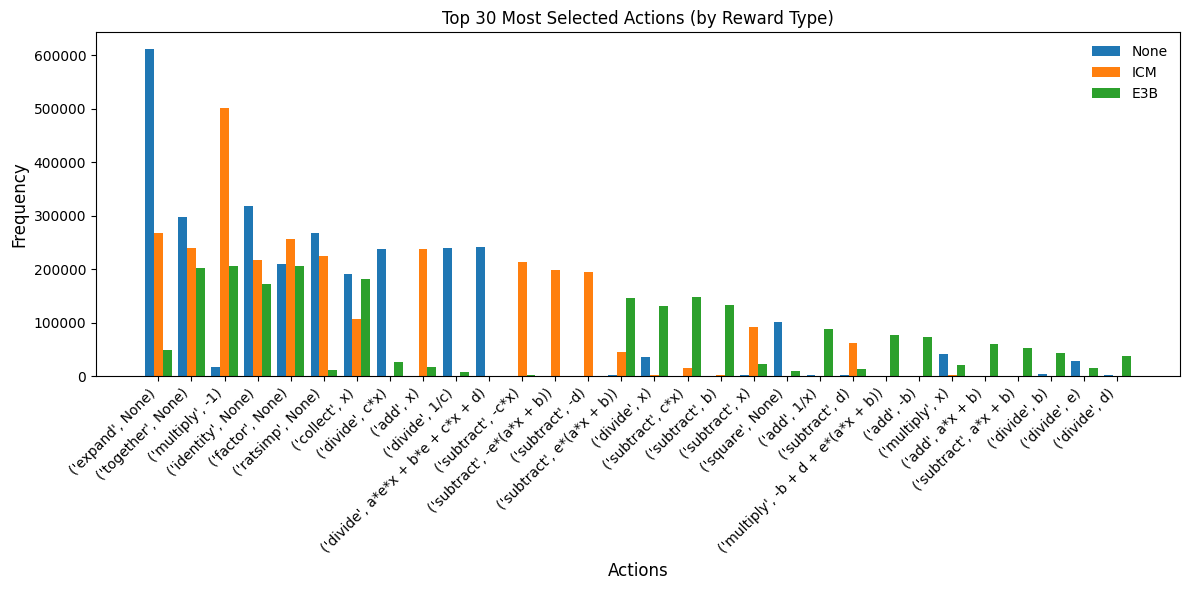

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_actions_all(actions_taken, reward_types, top_n=10):
    """
    Plots a side-by-side bar chart comparing the top_n most selected actions
    across multiple reward types.
    
    Parameters:
        actions_taken (dict): A dictionary where keys are reward type strings and 
            values are dictionaries mapping actions (or their string representations) 
            to counts.
        reward_types (list of str): List of reward type names to include.
        top_n (int): Number of top actions to display.
    """
    # Build a union of all keys from all reward types
    union_keys = set()
    for reward in reward_types:
        union_keys.update(actions_taken[reward].keys())
    union_keys = list(union_keys)
    
    # Compute the total frequency for each key across all reward types
    total_counts = {key: sum(actions_taken[reward].get(key, 0) for reward in reward_types) 
                    for key in union_keys}
    
    # Sort the union keys by total frequency in descending order and take top_n keys
    sorted_keys = sorted(union_keys, key=lambda k: total_counts[k], reverse=True)
    top_keys = sorted_keys[:top_n]
    
    # For each reward type, get the counts for these top actions.
    counts_per_reward = {reward: [actions_taken[reward].get(key, 0) for key in top_keys] 
                           for reward in reward_types}
    
    # Plot side-by-side bar charts
    x = np.arange(top_n)
    num_rewards = len(reward_types)
    width = 0.8 / num_rewards  # total bar group width divided by number of reward types
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, reward in enumerate(reward_types):
        # Compute offset for each reward type's bars
        offsets = x - 0.4 + i * width + width / 2
        ax.bar(offsets, counts_per_reward[reward], width, label=reward)
    
    ax.set_xlabel("Actions")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Top {top_n} Most Selected Actions (by Reward Type)")
    ax.set_xticks(x)
    ax.set_xticklabels(top_keys, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_actions_all(actions_taken, reward_types, top_n=30)

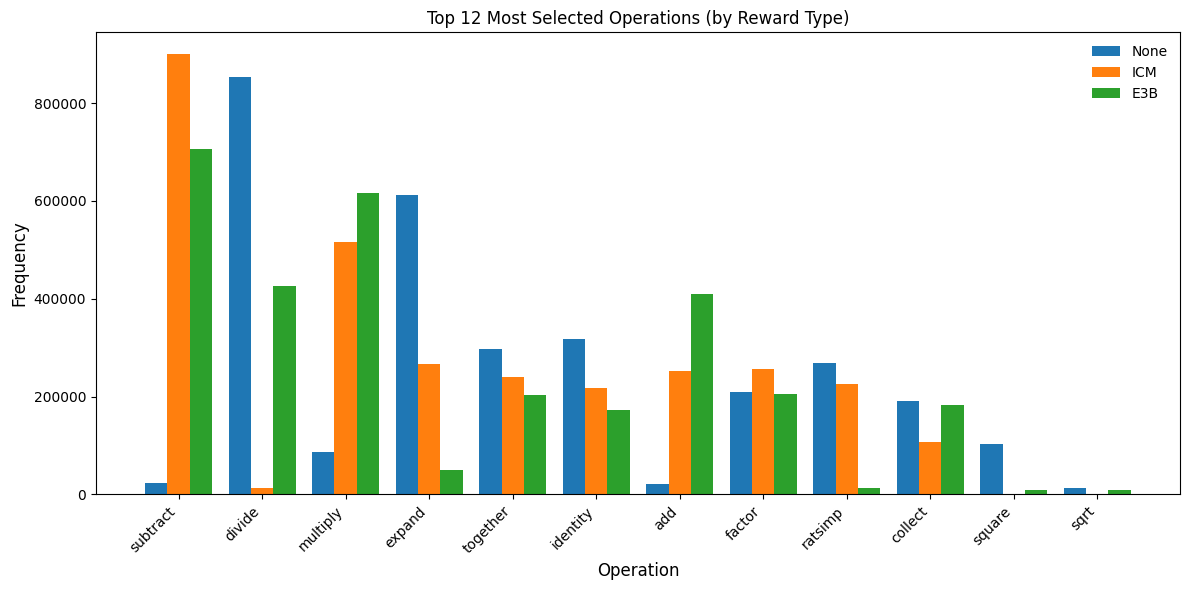

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_top_operations_all(actions_taken, reward_types, top_n=10):
    """
    Plots a side-by-side bar chart comparing the top_n most selected *operations*
    across multiple reward types.
    
    Parameters:
        actions_taken (dict): 
            Keys: reward type strings (e.g. "None", "ICM", "E3B").
            Values: dicts mapping (operation, term) -> counts, e.g.
                    { ('expand','None'): 100, ('multiply','x'): 50, ... }
        reward_types (list of str):
            List of reward type names to include, e.g. ["None", "ICM", "E3B"].
        top_n (int): Number of top operations to display.
    """
    # 1) Aggregate counts by operation (ignore 'term')
    #    We'll produce a dict-of-dicts: agg_by_op[reward][op] = total_count
    agg_by_op = {}
    for reward in reward_types:
        op_counts = defaultdict(int)
        for (op, term), count in actions_taken[reward].items():
            op_counts[op] += count
        agg_by_op[reward] = dict(op_counts)

    # 2) Collect all unique operations across reward types
    union_ops = set()
    for reward in reward_types:
        union_ops.update(agg_by_op[reward].keys())
    union_ops = list(union_ops)

    # 3) Sort operations by total frequency (summing across all reward types)
    total_counts = {
        op: sum(agg_by_op[rew].get(op, 0) for rew in reward_types)
        for op in union_ops
    }
    sorted_ops = sorted(union_ops, key=lambda op: total_counts[op], reverse=True)

    # Take the top_n operations (if fewer exist, use the available ones)
    top_ops = sorted_ops[:min(top_n, len(sorted_ops))]

    # 4) Build an array of counts for each reward type, restricted to top_ops
    counts_per_reward = {
        reward: [agg_by_op[reward].get(op, 0) for op in top_ops]
        for reward in reward_types
    }

    # 5) Create a side-by-side bar chart using the actual number of top operations
    n_ops = len(top_ops)
    x = np.arange(n_ops)
    num_rewards = len(reward_types)
    width = 0.8 / num_rewards  # width of each bar

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, reward in enumerate(reward_types):
        offset = x - 0.4 + i * width + width/2
        ax.bar(offset, counts_per_reward[reward], width, label=reward)

    ax.set_xlabel("Operation")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Top {n_ops} Most Selected Operations (by Reward Type)")
    ax.set_xticks(x)
    ax.set_xticklabels(top_ops, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
reward_types = ["None", "ICM", "E3B"]
plot_top_operations_all(actions_taken, reward_types, top_n=30)


/var/folders/y2/808x0vrs0219dlwh974ks0q00000gn/T/ipykernel_91836/4047386310.py:62: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


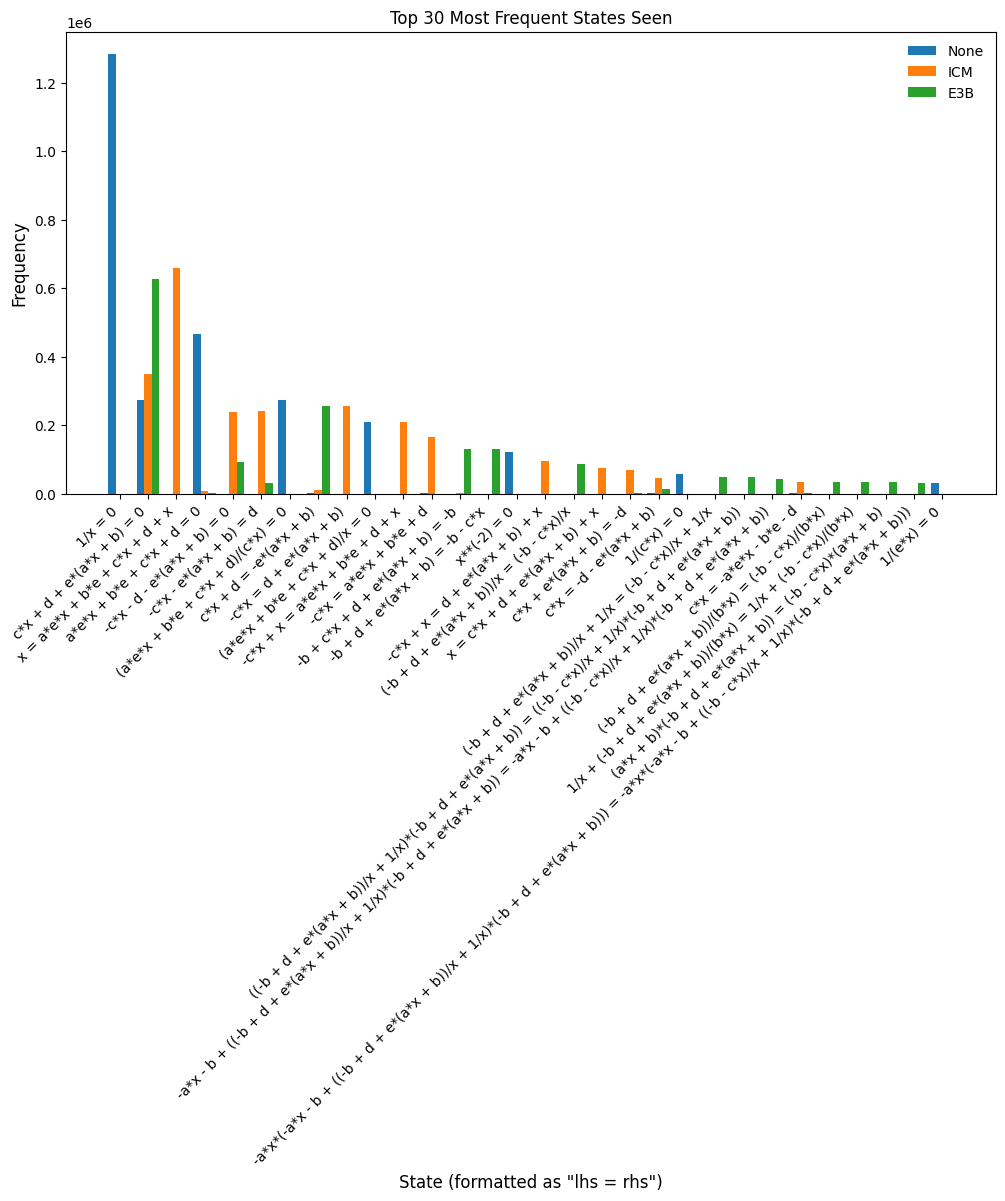

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_states_all(states_seen, reward_types, top_n=10, exclude_state=None):
    """
    Plots a side-by-side bar chart comparing the top_n most frequent states
    across multiple reward types.
    
    Parameters:
        states_seen (dict): Dictionary mapping reward type (str) to a dict of 
            {state (str): count (int)}.
        reward_types (list of str): List of reward type names to include.
        top_n (int): Number of top states to display.
        exclude_state (str, optional): A state string to exclude from analysis.
    """
    # Build the union of all keys across all reward types (with optional filtering)
    union_keys = set()
    for reward in reward_types:
        # Optionally filter out the starting state if provided
        if exclude_state is not None:
            filtered_states = {k: v for k, v in states_seen[reward].items() if k != exclude_state}
        else:
            filtered_states = states_seen[reward]
        union_keys.update(filtered_states.keys())
    union_keys = list(union_keys)
    
    # Compute the total frequency for each state across all reward types
    total_counts = {
        key: sum(states_seen[r].get(key, 0) for r in reward_types)
        for key in union_keys
    }
    
    # Sort the keys by total frequency in descending order and select top_n
    sorted_keys = sorted(union_keys, key=lambda k: total_counts[k], reverse=True)
    top_keys = sorted_keys[:top_n]
    
    # For each reward type, get the counts for these top keys
    counts_per_reward = {
        reward: [states_seen[reward].get(key, 0) for key in top_keys]
        for reward in reward_types
    }
    
    # Set up side-by-side bar chart parameters
    x = np.arange(top_n)
    num_rewards = len(reward_types)
    width = 0.8 / num_rewards  # total width of bar groups
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, reward in enumerate(reward_types):
        # Calculate offset for each reward type's bars
        offsets = x - 0.4 + i * width + width / 2
        ax.bar(offsets, counts_per_reward[reward], width, label=reward)
    
    ax.set_xlabel('State (formatted as "lhs = rhs")')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Top {top_n} Most Frequent States Seen")
    ax.set_xticks(x)
    ax.set_xticklabels(top_keys, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a dictionary "states_seen" loaded as follows:
# states_seen = {
#     'None': states_seen_none,
#     'ICM': states_seen_icm,
#     'E3B': states_seen_E3B
# }
# And if the starting state (to be excluded) is "0 = 0", then call:
plot_top_states_all(states_seen, reward_types=['None', 'ICM', 'E3B'], top_n=30)


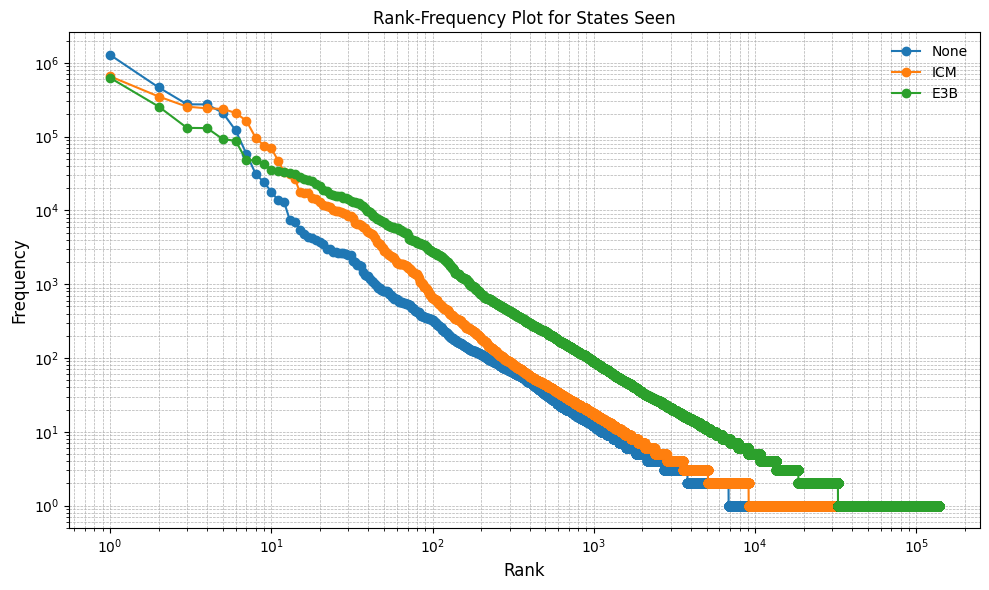

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rank_frequency_all(states_seen_dict, reward_types, top_n=None, starting_state=None):
    """
    Plots a rank-frequency (Zipf) plot for states seen across multiple reward types.
    
    Parameters:
        states_seen_dict (dict): A dictionary mapping reward type (str) to a dictionary of 
                                 {state (str): count (int)}.
        reward_types (list of str): List of reward type names to include in the plot.
        top_n (int, optional): If provided, only plot the top_n most frequent states for each reward type.
        starting_state (str, optional): A state string to be excluded from the analysis.
    """
    plt.figure(figsize=(10, 6))
    
    for reward in reward_types:
        # Get the states dictionary for the current reward
        states = states_seen_dict[reward]
        
        # Optionally filter out the starting state
        if starting_state is not None:
            filtered_states = {k: v for k, v in states.items() if k != starting_state}
        else:
            filtered_states = states
        
        # Sort the frequencies in descending order
        freqs = sorted(filtered_states.values(), reverse=True)
        
        # Optionally limit to top_n frequencies
        if top_n is not None:
            freqs = freqs[:top_n]
        
        # Generate rank array (1-indexed)
        ranks = np.arange(1, len(freqs) + 1)
        
        # Plot on a log-log scale
        plt.loglog(ranks, freqs, marker='o', linestyle='-', label=reward)
    
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Rank-Frequency Plot for States Seen')
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

# Plot comparing 'None' and 'ICM' conditions, excluding the starting state "0 = 0"
plot_rank_frequency_all(states_seen, reward_types=["None", "ICM", 'E3B'], top_n=None, starting_state="0 = 0")

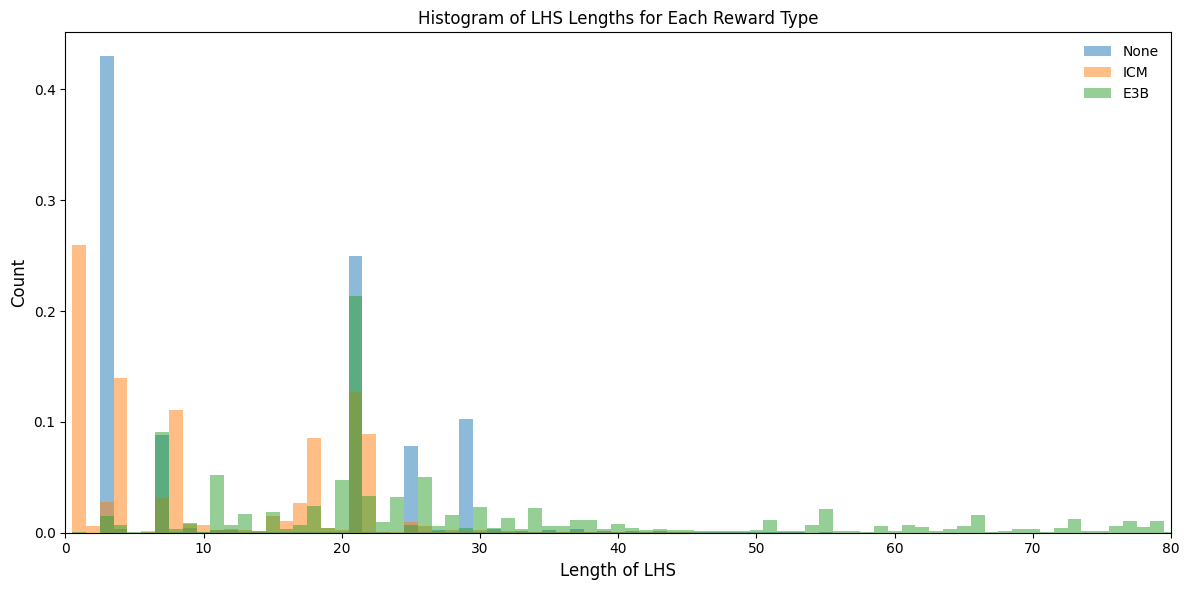

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assume states_seen is a dictionary mapping reward type -> dictionary mapping "lhs = rhs" -> count
# For example:
# states_seen = {
#     "None": states_seen_none,
#     "ICM": states_seen_icm,
#     "E3B": states_seen_E3B
# }

# Create a dictionary to hold lists of LHS lengths weighted by their counts
lhs_lengths = {}

for reward, states in states_seen.items():
    lengths = []
    for state, count in states.items():
        # Extract the left-hand side from the state (assumes "lhs = rhs" format)
        lhs = state.split(" = ")[0]
        # Append the length of lhs, repeated 'count' times
        lengths.extend([len(lhs)] * count)
    lhs_lengths[reward] = lengths

# Determine appropriate bins for integer lengths
all_lengths = []
for reward in lhs_lengths:
    all_lengths.extend(lhs_lengths[reward])
bins = np.arange(0, max(all_lengths) + 2) - 0.5  # bin edges for integer bins


# Plot histogram for each reward type on the same figure for comparison
plt.figure(figsize=(12, 6))
for reward in lhs_lengths:
    plt.hist(lhs_lengths[reward], bins=bins, alpha=0.5, label=reward, density=True)

plt.xlabel("Length of LHS")
plt.ylabel("Count")
plt.title("Histogram of LHS Lengths for Each Reward Type")
plt.xlim([0,80])
#plt.ylim([0,0000])
plt.legend()
plt.tight_layout()
plt.show()